In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "/home/bradhakrishnan/ECE276A_PR2/code")
data_base_path= "/home/bradhakrishnan/ECE276A_PR2/data/"

In [3]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.linalg import expm
import jax
import matplotlib.pyplot as plt
import load_data 

jax.config.update("jax_enable_x64", True)
dataset_idx =20

encoder_data= np.load(data_base_path+"Encoders20.npz")
imu_data= np.load(data_base_path+'Imu20.npz')

In [4]:
imu_angular = imu_data['angular_velocity']
imu_linear = imu_data['linear_acceleration']
imu_ts = imu_data['time_stamps']

# DATA format of encoder: [FR, FL, RR, RL]
encoder_counts= encoder_data["counts"]
encoder_ts= encoder_data["time_stamps"]

(encoder_counts, encoder_ts,
lidar_angle_min, lidar_angle_max, lidar_angle_increment,
lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamps,
imu_angular, imu_linear, imu_ts,
disp_stamps, rgb_stamps) = load_data.load_dataset(20)

In [5]:
def velocity_calculator(encoder_data, encoder_ts):
    #skipping the 0th index
    del_ts= encoder_ts[1:] - encoder_ts[:-1]
    VL = 0.5*jnp.sum(encoder_data[[0, 2], 1:], axis=0)*0.0022/del_ts
    VR = 0.5*np.sum(encoder_data[[1, 3], 1:], axis=0)*0.0022/del_ts
    robo_vel = (VL+VR)/2
    return robo_vel
    
robo_vel=velocity_calculator(encoder_counts, encoder_ts)


In [6]:
def twist_creator(lin_vel, ang_vel):
    # Create a 4x4 matrix of zeros
    twist = np.zeros((4, 4))
    
    # Set the last column to lin_vel (with a zero appended at the end)
    vel_x= lin_vel
    vel_y= 0
    vel_z=0
    twist[0:3, 3] = np.array([vel_x, vel_y, vel_z])
    
    # Set the element at first row, second column to -ang_vel[2]
    twist[0, 1] = -ang_vel[2]
    
    # Set the element at second row, first column to the third element of lin_vel
    twist[1, 0] = ang_vel[2]
    
    return twist

In [7]:
def time_sync(time_stamp_1, time_stamp_2):
    ts_synced = {}
    for ts in time_stamp_1:
        ts_synced[ts] = np.argmin(np.abs(ts-time_stamp_2))
    return ts_synced

imu_sync_map= time_sync(encoder_ts, imu_ts)
lidar_sync_map = time_sync(encoder_ts, lidar_stamps)

disp_sync_map= time_sync(encoder_ts, disp_stamps)
rgb_sync_map= time_sync(encoder_ts, rgb_stamps)

In [8]:
def motion_model(prev_pose, lin_vel, angular_vel,del_T):
    twist= twist_creator(lin_vel,angular_vel)
    pred_T= prev_pose@expm(del_T* twist)
    return pred_T
    

In [9]:
T_0= jnp.eye(4)
encoder_poses= [T_0]
del_ts= encoder_ts[1:] - encoder_ts[:-1]
for ii in range(0,encoder_counts.shape[-1]-1):
    ang_vel= imu_angular[:,imu_sync_map[encoder_ts[ii]]]
    lin_vel= robo_vel[ii]
    del_T= del_ts[ii]
    encoder_poses.append(motion_model(encoder_poses[ii],lin_vel, ang_vel, del_T))
encoder_poses= np.array(encoder_poses)

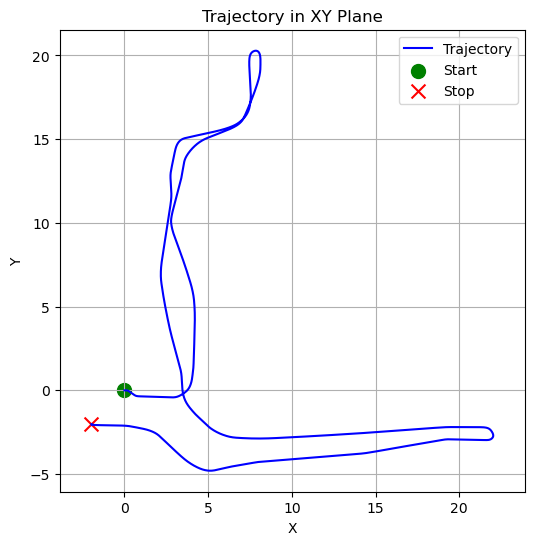

In [10]:

import matplotlib.pyplot as plt

def plot_trajectory(poses, additional_poses=None, title="Trajectory in XY Plane"):
    """
    Plots the trajectory of a sequence of poses in the XY plane.

    Parameters:
    - poses: A list or array of transformation matrices (4x4).
    - additional_poses: An optional list or array of transformation matrices (4x4) for the second trajectory to be plotted in orange.
    - title: Title for the plot (default: "Trajectory in XY Plane").
    """
    xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in poses])
    
    plt.figure(figsize=(6, 6))
    
    # Plot the primary trajectory
    plt.plot(xy_positions[:, 0], xy_positions[:, 1], label='Trajectory', color='blue')
    plt.scatter(xy_positions[0, 0], xy_positions[0, 1], color='green', label='Start', s=100, marker='o')
    plt.scatter(xy_positions[-1, 0], xy_positions[-1, 1], color='red', label='Stop', s=100, marker='x')

    if additional_poses is not None:
        additional_xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in additional_poses])
        plt.plot(additional_xy_positions[:, 0], additional_xy_positions[:, 1], label='Additional Trajectory', color='orange')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling on both axes.
    plt.legend()
    plt.show()

plot_trajectory(encoder_poses)

In [11]:
def get_lidar_pc(lidar_raw_vals,  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment):
    lidar_angles= np.linspace(lidar_angle_min, lidar_angle_max, int((lidar_angle_max - lidar_angle_min) / lidar_angle_increment) + 1)
    lidar_val_mask = np.where((lidar_raw_vals > lidar_range_min) & (lidar_raw_vals < lidar_range_max), True, False)
    lidar_raw_vals_masked = lidar_raw_vals[lidar_val_mask]
    lidar_angles_masked = lidar_angles[lidar_val_mask]
    lidar_x = lidar_raw_vals_masked * np.cos(lidar_angles_masked) 
    lidar_y = lidar_raw_vals_masked * np.sin(lidar_angles_masked)
    lidar_z = np.zeros(lidar_raw_vals_masked.shape[0])
    return np.column_stack((lidar_x,lidar_y,lidar_z))

In [12]:
# pc=get_lidar_pc(lidar_ranges[:,0],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])

In [13]:
import ICP_stuff
from tqdm import tqdm

prev_pose= T_0
accumulated_pose= T_0
lidarToBodyPose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))
trajectory= []
for idx in tqdm(range(encoder_ts.shape[0]-1)):
    # Time t data
    enc_ts_t= encoder_ts[idx]
    lidar_pc_at_t = get_lidar_pc(lidar_ranges[:,lidar_sync_map[enc_ts_t]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    # Time T+1 data
    enc_ts_t1 = encoder_ts[idx+1]
    lidar_pc_at_t1= get_lidar_pc(lidar_ranges[:,lidar_sync_map[enc_ts_t1]],  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    # motion model
    del_T = enc_ts_t1- enc_ts_t
    motion_model_pose = motion_model(prev_pose, lin_vel=robo_vel[ii], angular_vel=imu_angular[:,imu_sync_map[encoder_ts[ii]]], del_T=del_T  )
    icp_pose= ICP_stuff.ICP(lidar_pc_at_t1,lidar_pc_at_t, motion_model_pose)
    
    accumulated_pose= accumulated_pose@icp_pose
    trajectory.append(accumulated_pose)


  6%|▌         | 309/4955 [00:14<03:38, 21.31it/s]


KeyboardInterrupt: 

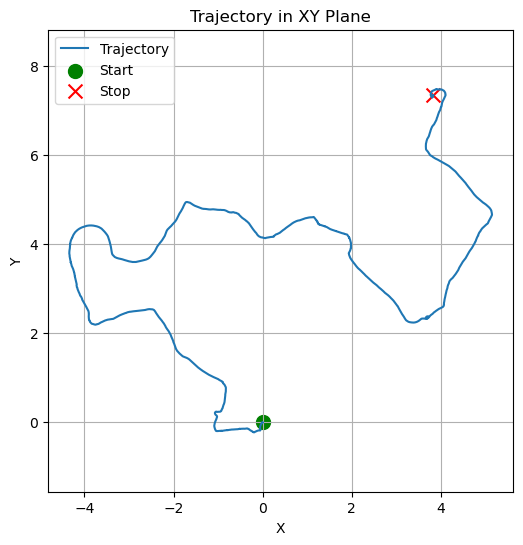

In [85]:
plot_trajectory(trajectory)

In [14]:
import ICP_stuff
from tqdm import tqdm
accumulated_pose = np.identity(4)
icp_traj = []
lidar_body_pose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))

for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts_at_t = encoder_ts[idx]
    enc_ts_at_t1 = encoder_ts[idx+1]
    encoder_pred_poses = encoder_poses[idx]

    # LTDAW stuff at time t
    lidar_range_val_at_t = lidar_ranges[:, lidar_sync_map[enc_ts_at_t]]
    lidar_pc_at_t = get_lidar_pc(lidar_range_val_at_t, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t = encoder_poses[idx] @ lidar_body_pose

    # LTDAW stuff at time t+1
    lidar_range_val_at_t1 = lidar_ranges[:, lidar_sync_map[enc_ts_at_t1]]  
    lidar_pc_at_t1 = get_lidar_pc(lidar_range_val_at_t1,lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t1 = encoder_poses[idx+1] @ lidar_body_pose

    init_pose_for_ICP = np.linalg.inv(pose_at_t) @ pose_at_t1

    icp_estimated_pose = ICP_stuff.ICP(lidar_pc_at_t, lidar_pc_at_t1, init_pose_for_ICP)

    accumulated_pose = accumulated_pose @ icp_estimated_pose
    icp_traj.append(accumulated_pose)

icp_traj = np.array(icp_traj)

100%|██████████| 4955/4955 [01:06<00:00, 74.58it/s] 


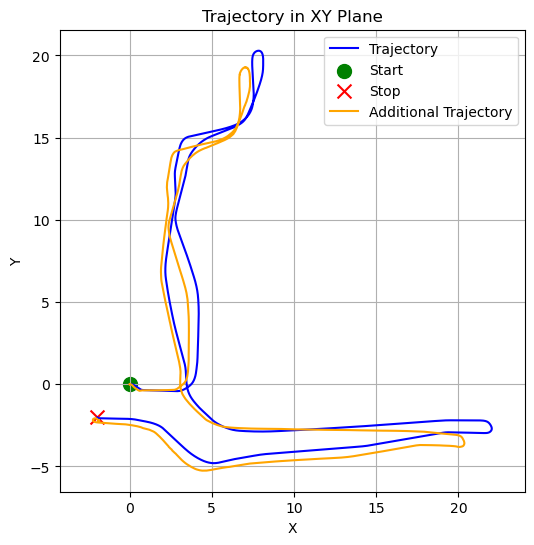

In [15]:
plot_trajectory(encoder_poses,icp_traj)

# occupancy grid

In [16]:
import numpy as np
import pr2_utils
# Initialize a grid map
MAP = {}
MAP['res'] = np.array([0.05, 0.05])    # meters
MAP['min'] = np.array([-20.0, -20.0])  # meters
MAP['max'] = np.array([30.0, 30.0])    # meters
MAP['size'] = np.ceil((MAP['max'] - MAP['min']) / MAP['res']).astype(int)
isEven = MAP['size']%2==0
MAP['size'][isEven] = MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
MAP['map'] = np.zeros(MAP['size'])

In [17]:
def get_map_coords(xy, MAP):
    return np.floor((xy - MAP['min']) / MAP['res']).astype(int)

In [18]:
for idx in tqdm(range(encoder_ts.shape[-1]-1)):
    enc_ts = encoder_ts[idx]
    curr_pose= icp_traj[idx] @ lidar_body_pose
    
    curr_R, curr_p= ICP_stuff.get_R_and_P(curr_pose)

    lidar_range_val = lidar_ranges[:, lidar_sync_map[enc_ts]]
    lidar_pc= get_lidar_pc(lidar_range_val, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    
    lidar_pc= ICP_stuff.rotate_pc(R=curr_R, pc=lidar_pc)+curr_p
    
    lidar_xy_pts= lidar_pc[:,:2]

    lidar_grid_pts= get_map_coords(lidar_xy_pts, MAP)-1
    
    lidar_grid_x= lidar_grid_pts[:,0]
    lidar_grid_y= lidar_grid_pts[:,1]

    start_pt=get_map_coords(curr_p[:2],MAP)

    for ii in range(lidar_grid_x.shape[0]):
        x,y = pr2_utils.bresenham2D(start_pt[0],start_pt[1], lidar_grid_x[ii], lidar_grid_y[ii])
        MAP['map'][y.astype(np.int32)[:-1], x.astype(np.int32)[:-1]] -= np.log(4)

    MAP['map'][lidar_grid_y, lidar_grid_x] += np.log(4)

    MAP['map'][np.where(MAP['map'] < -4*np.log(4))] = -4*np.log(4)
    MAP['map'][np.where(MAP['map'] > 4*np.log(4))] = 4*np.log(4)

100%|██████████| 4955/4955 [03:34<00:00, 23.08it/s]


In [19]:
# plt.figure(figsize=(10, 10))
# plt.title('Occupancy Grid')
# plt.imshow(1/(1+np.exp(-MAP['map'])), cmap='gray')
# plt.savefig('./outputs/LiDAR_scan_dt_{}.jpg'.format(dataset_idx))
# # plt.close()

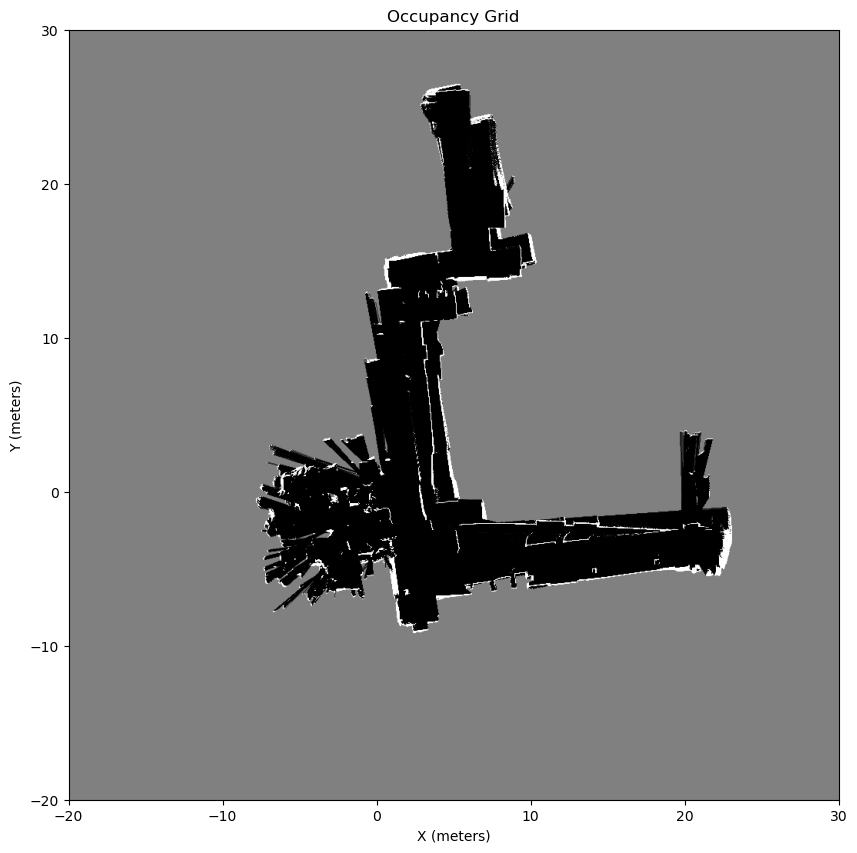

In [93]:
plt.figure(figsize=(10, 10))
plt.title('Occupancy Grid')

plt.imshow(1/(1+np.exp(-MAP['map'])), cmap='gray', origin='lower', extent=[MAP['min'][0], MAP['max'][0], MAP['min'][1], MAP['max'][1]])

# Set axis labels with scale information
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

# Save and display
plt.savefig('./outputs/occupancy_grid_{}.jpg'.format(dataset_idx))
plt.show()


# texture Mapping


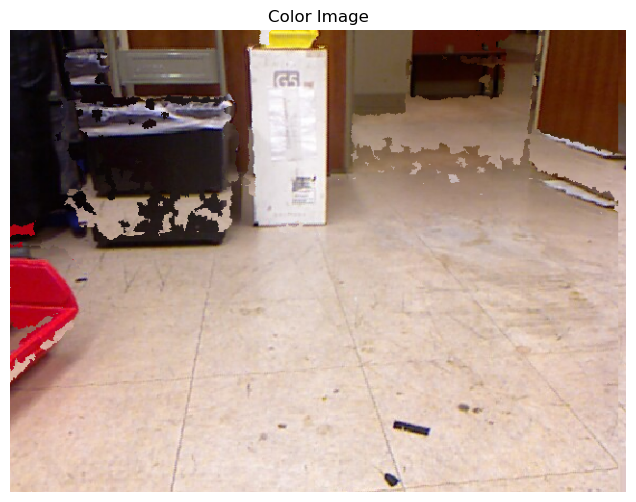

True

In [23]:
import numpy as np
import cv2
import open3d as o3d

# generate sample pc from disparity images

# IMREAD_UNCHANGED ensures we preserve the precision on depth
disp_img = cv2.imread("../data/dataRGBD/Disparity20/disparity20_1.png", cv2.IMREAD_UNCHANGED)

# note that cv2 imports as bgr, so colors may be wrong.
bgr_img = cv2.imread("../data/dataRGBD/RGB20/rgb20_1.png")
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

# from writeup, compute correspondence
height, width = disp_img.shape

dd = np.array(-0.00304 * disp_img + 3.31)
depth = 1.03 / dd

mesh = np.meshgrid(np.arange(0, height), np.arange(0, width), indexing='ij')  
i_idxs = mesh[0].flatten()
j_idxs = mesh[1].flatten()

rgb_i = np.array((526.37 * i_idxs + 19276 - 7877.07 * dd.flatten()) / 585.051, dtype=np.int32)  # force int for indexing
rgb_j = np.array((526.37 * j_idxs + 16662) / 585.051, dtype=np.int32)

# some may be out of bounds, just clip them
rgb_i = np.clip(rgb_i, 0, height - 1)
rgb_j = np.clip(rgb_j, 0, width - 1)

colors = rgb_img[rgb_i, rgb_j]

# lets visualize the image using our transformation to make sure things look correct (using bgr for opencv)
bgr_colors = bgr_img[rgb_i, rgb_j]
# cv2.imshow("color", bgr_colors.reshape((height, width, 3)))
# Convert BGR to RGB if using OpenCV
rgb_colors = bgr_colors.reshape((height, width, 3))[:, :, ::-1]  # Swap channels from BGR to RGB

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(rgb_colors)
plt.axis("off")  # Hide axes
plt.title("Color Image")
plt.show()

uv1 = np.vstack([j_idxs, i_idxs, np.ones_like(i_idxs)])
K = np.array([[585.05, 0, 242.94],
              [0, 585.05, 315.84],
              [0, 0, 1]])

# project images to 3d points
points = depth.flatten() * (np.linalg.inv(K) @ uv1)

oRr = np.array([[0, -1, 0],
                [0, 0, -1],
                [1, 0, 0]])
# we want rRo because we have points in optical frame and want to move them to the regular frame.
points = oRr.T @ points

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.T)
pcd.colors = o3d.utility.Vector3dVector(colors / 255)  # open3d expects color channels 0-1, opencv uses uint8 0-255

origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.5)  # visualize the camera regular frame for reference.
# o3d.visualization.draw([pcd, origin])  # display the pointcloud and origin
o3d.io.write_point_cloud("/home/bradhakrishnan/ECE276A_PR2/code/open_3d plots/point_cloud.ply", pcd)



In [118]:
import ICP_stuff
import transforms3d as t3d

# Initialize a grid map
TEXTURE_MAP = {}
TEXTURE_MAP['res'] = np.array([0.05, 0.05])    # meters
TEXTURE_MAP['min'] = np.array([-20.0, -20.0])  # meters
TEXTURE_MAP['max'] = np.array([30.0, 30.0])    # meters
TEXTURE_MAP['size'] = np.ceil((TEXTURE_MAP['max'] - TEXTURE_MAP['min']) / TEXTURE_MAP['res']).astype(int)
isEven = TEXTURE_MAP['size']%2==0
TEXTURE_MAP['size'][isEven] = TEXTURE_MAP['size'][isEven]+1 # Make sure that the map has an odd size so that the origin is in the center cell
TEXTURE_MAP['map'] = np.zeros((TEXTURE_MAP['size'][0], TEXTURE_MAP['size'][1], 3))

In [119]:
for idx in tqdm(range(encoder_ts.shape[0]-1)):
    
    icp_pose= icp_traj[idx]
    enc_ts = encoder_ts[idx]
    
    rgb_file_num= rgb_sync_map[enc_ts]+1
    bgr_img = cv2.imread(f"../data/dataRGBD/RGB{dataset_idx}/rgb{dataset_idx}_{rgb_file_num}.png")
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    disp_file_num = disp_sync_map[enc_ts]+1
    disp_img = cv2.imread(f"../data/dataRGBD/Disparity{dataset_idx}/disparity{dataset_idx}_{disp_file_num}.png", cv2.IMREAD_UNCHANGED)
    height, width = disp_img.shape
    dd = np.array(-0.00304 * disp_img + 3.31)
    depth = 1.03 / dd

    mesh = np.meshgrid(np.arange(0, height), np.arange(0, width), indexing='ij')  
    i_idxs = mesh[0].flatten()
    j_idxs = mesh[1].flatten()
    
    rgb_i = np.array((526.37 * i_idxs + 19276 - 7877.07 * dd.flatten()) / 585.051, dtype=np.int32)  # force int for indexing
    rgb_j = np.array((526.37 * j_idxs + 16662) / 585.051, dtype=np.int32)

    # some may be out of bounds, just clip them
    rgb_i = np.clip(rgb_i, 0, height - 1)
    rgb_j = np.clip(rgb_j, 0, width - 1)
    
    colors = rgb_img[rgb_i, rgb_j]
    # colors = colors / 255
    uv1 = np.vstack([j_idxs, i_idxs, np.ones_like(i_idxs)])

    K = np.array([[585.05, 0, 242.94],
              [0, 585.05, 315.84],
              [0, 0, 1]])
 
    uv1= depth.flatten() * (np.linalg.inv(K) @ uv1) # rotate the given point by K^-1
    oRr = np.array([[0, -1, 0],
                [0, 0, -1],
                [1, 0, 0]])
    # we want rRo because we have points in optical frame and want to move them to the regular frame.
    points = oRr.T @ uv1
    points_homogeneous = np.vstack([points, np.ones(points.shape[1])])
    # now do cam -> body stuff
    cam2body_p= np.array([0.18,0.005,0.36])
    cam2body_R = t3d.euler.euler2mat(0,0.36,0.021)
    cam2body_T= ICP_stuff.get_pose(cam2body_R, cam2body_p)
    points_body = cam2body_T @ points_homogeneous
    

    points_world = icp_pose @ points_body
    uv_body_xy = points_world[:2, :].T
    uv_body_z = points_world[2, :]

    norms = np.linalg.norm(points_world[:3, :], axis=0)
    
    valid_indices = np.where((uv_body_z < 0.5))

    # if valid_indices[0].shape[0] ==0:
    #     import ipdb; ipdb.set_trace()
    #     print(valid_indices)
    uv_body_xy = uv_body_xy[valid_indices]
    colors = colors[valid_indices]/255.0

    # Map world coordinates to grid indices
    grid_xy = np.round((uv_body_xy - TEXTURE_MAP['min']) / TEXTURE_MAP['res']).astype(int)
    grid_x, grid_y = grid_xy[:, 0], grid_xy[:, 1]

    # Filter valid grid indices
    valid_mask = (grid_x >= 0) & (grid_x < TEXTURE_MAP['size'][0]) & \
                 (grid_y >= 0) & (grid_y < TEXTURE_MAP['size'][1])
    grid_x, grid_y, colors = grid_x[valid_mask], grid_y[valid_mask], colors[valid_mask]

    # Update the texture map
    TEXTURE_MAP['map'][grid_y, grid_x] = colors
    # texture_map_xy = get_map_coords(uv_body_xy, TEXTURE_MAP)
    # TEXTURE_MAP['map'][texture_map_xy[:,1], texture_map_xy[:,0], :] = colors
    if idx==10:
        continue

100%|██████████| 4955/4955 [10:38<00:00,  7.76it/s]


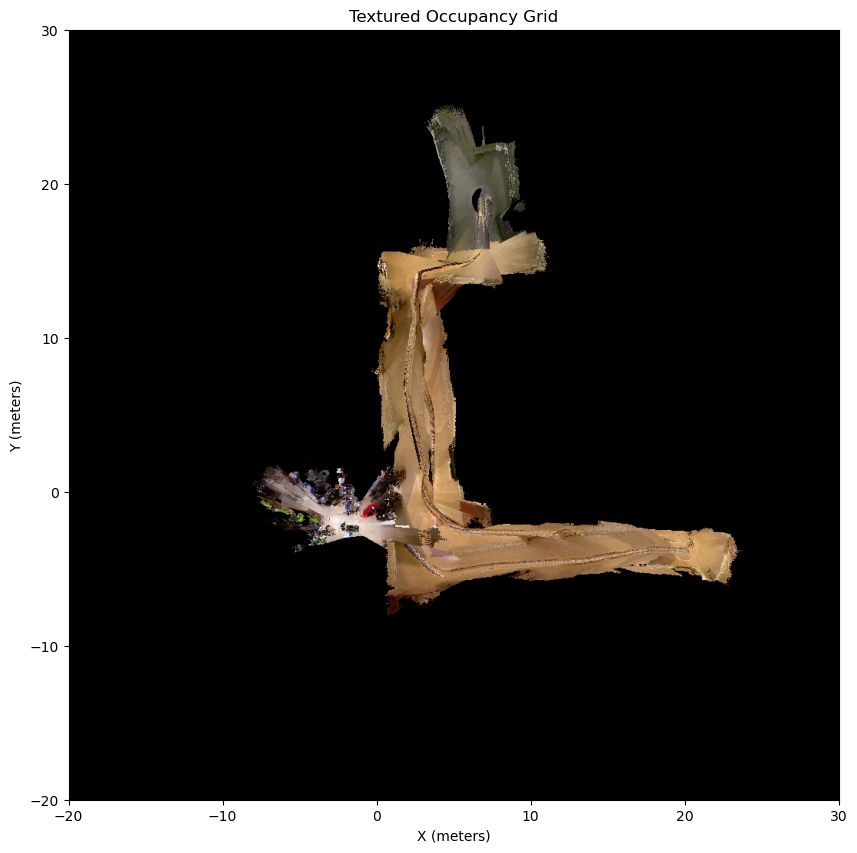

In [120]:
import datetime

plt.figure(figsize=(10, 10))
plt.title('Textured Occupancy Grid')
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

plt.imshow(TEXTURE_MAP['map'], origin='lower', extent=[TEXTURE_MAP['min'][0], TEXTURE_MAP['max'][0], TEXTURE_MAP['min'][1], TEXTURE_MAP['max'][1]])

# Set axis labels with scale information
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

# Save and display
plt.savefig('./outputs/Textured_occupancy_{}_{}.jpg'.format(dataset_idx, timestamp))
plt.show()

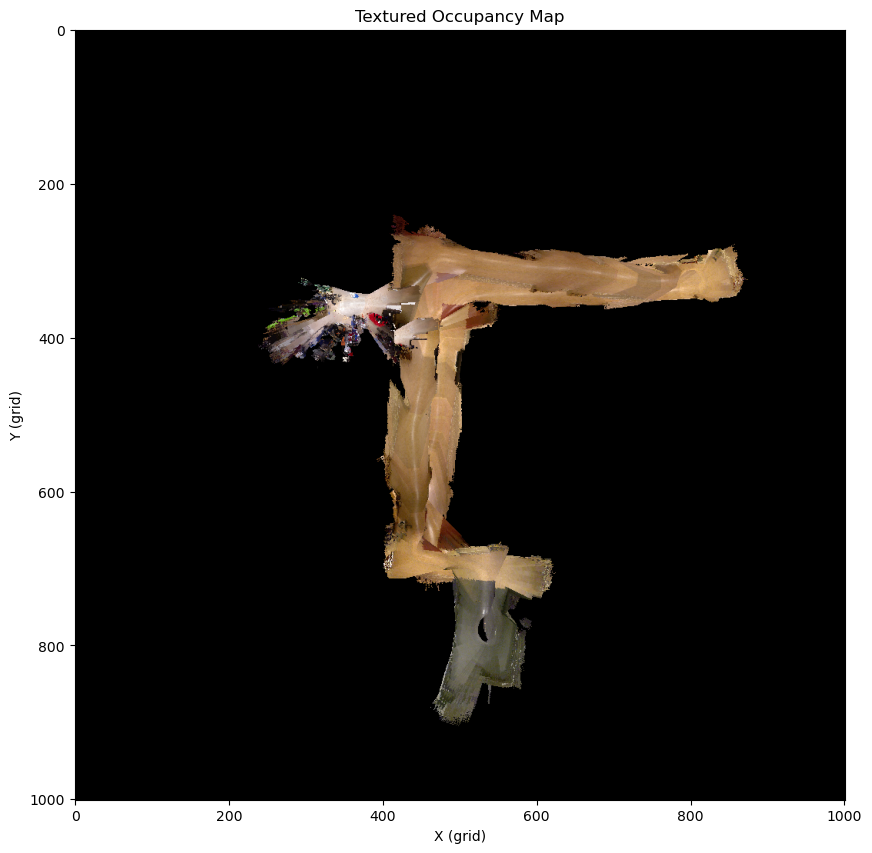

In [105]:
# Plot the textured occupancy map
plt.figure(figsize=(10, 10))
plt.imshow(TEXTURE_MAP['map'])
plt.title("Textured Occupancy Map")
plt.xlabel("X (grid)")
plt.ylabel("Y (grid)")
plt.show()

In [110]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_world[:3, :].T[valid_indices])
pcd.colors = o3d.utility.Vector3dVector(colors)  # open3d expects color channels 0-1, opencv uses uint8 0-255

origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.5)  # visualize the camera regular frame for reference.
# o3d.visualization.draw([pcd, origin])  # display the pointcloud and origin
o3d.io.write_point_cloud("/home/bradhakrishnan/ECE276A_PR2/code/open_3d plots/point_cloud_dum.ply", pcd)

True

In [ ]:
plt.imshow(rgb_img)

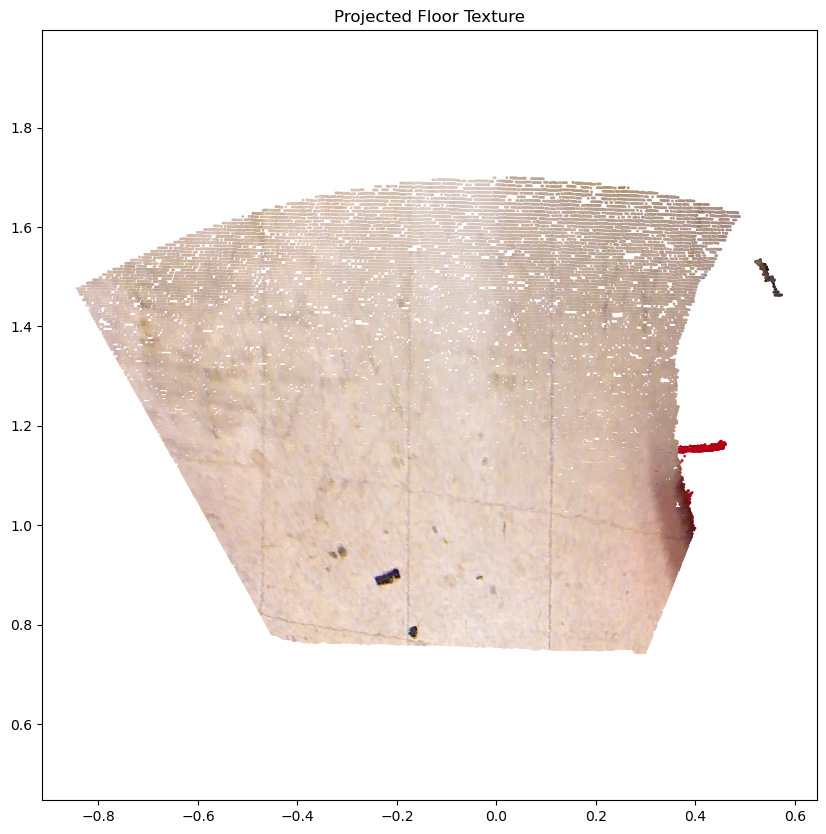

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(uv_body_xy[:, 1],uv_body_xy[:, 0],c=colors, s=1)  # Small dots for density
plt.title("Projected Floor Texture")
plt.axis("equal")  # Preserve aspect ratio
plt.show()


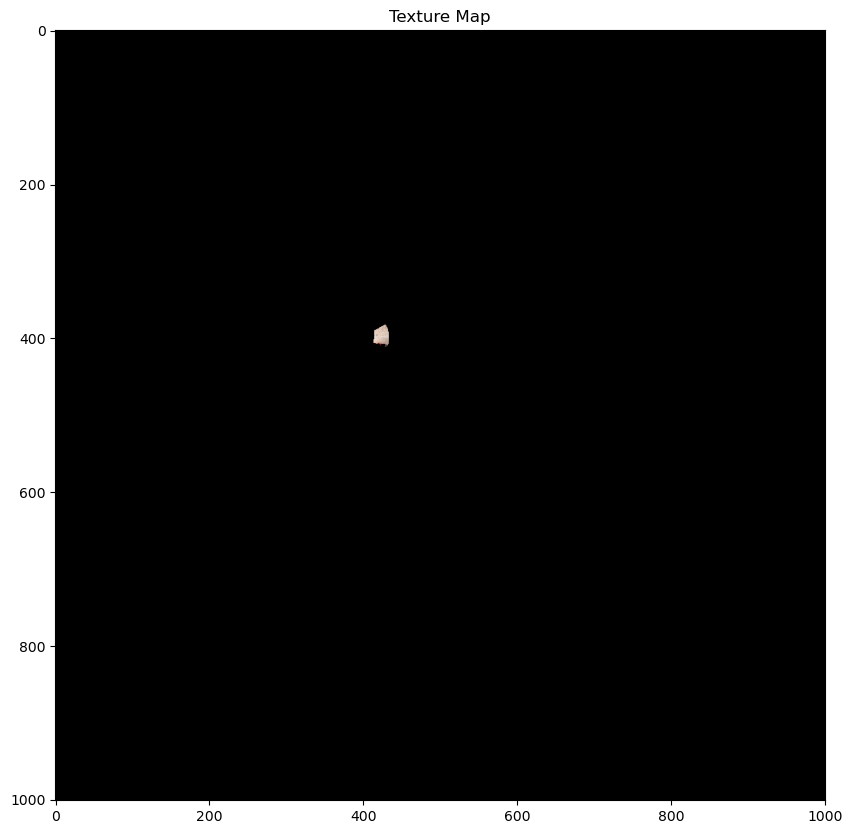

In [31]:
plt.figure(figsize=(10, 10))
plt.title('Texture Map')
plt.imshow(TEXTURE_MAP['map'], cmap='gray')
